##### Los features que vamos a utilizar son:

Potencia para cada banda de frecuencia (Delta, Theta, Alpha, Beta y Gamma)

Potencia normalizada para las mismas bandas de frecuencia.

In [7]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn
import pandas as pd
import glob 
import sys
import getopt
from scipy import stats
from scipy.signal import welch
from scipy.io import loadmat  # this is the SciPy module that loads mat-files

In [ ]:
def analisis_espectral(serie):
    """ Transformada de Welch para la serie de tiempo serie"""

    return welch(serie, fs=250, nfft=2048, nperseg=201)


In [549]:
#TP2
def Mat2Data(filename):
    """ Lee los datos desde filename (.mat) a un np array """
    
    mat = loadmat(filename)  # load mat-file    
    mdata = mat['data']  # variable in mat file
    return mdata


In [10]:
#TP2
# Calculo la potencia total del sujeto en cada banda
def p_total(sujeto, min, max, escala=1):
    """ Devuelve la potencia total en la banda [min, max) """
    
    return np.sum(filtrar(sujeto, min, max, escala))

In [12]:
#TP2 b) Calcular los valores de cada banda de frecuencia, promediados entre los electrodos (todos) y epochs para cada sujeto.
def b1(sujeto):
    """ Para un sujeto hacer el analisis espectral
    para la señal promedio entre todos los  electrodos y las epochs
    
    sujeto : numpy array
    """
    
    a=[]
    for epoch in range(0, len(sujeto)):
        a.append(np.mean(sujeto[epoch],axis=0)) # promedio electrodos
    b = np.mean(a,axis=0) # promedio epochs
    freq,pot = analisis_espectral(b)
    
    return freq,pot


In [13]:
#TP2
def filtrar(sujeto, min, max, escala=1):
    """ Dado un sujeto devuelve la potencia de la señal
    del promedio entre epocs y electrodos en la banda 
    [min, max)
    
    sujeto : numpy array
    """

    freq, pot = b1(sujeto)
    banda_pot = [escala * p[1] for p in zip(freq, pot) if p[0] < max and p[0] >= min]
    return banda_pot

#TP2
delta = p_total(sujeto, 0, 4.0)
theta = p_total(sujeto, 4.0, 8.0)
alpha = p_total(sujeto, 8.0, 13.0)
beta = p_total(sujeto, 13.0, 30.0)
gamma = p_total(sujeto, 30.0, 125.0)


In [14]:
#solo para ver 
cols = ['delta', 'theta', 'alpha', 'beta', 'gamma']
print(' | '.join(cols))
potencia = [delta, theta, alpha, beta, gamma]
print(' | '.join(map(str, potencia)))

delta | theta | alpha | beta | gamma
5.97138742365e-16 | 2.47715409367e-15 | 3.37764369628e-16 | 1.94457223745e-16 | 9.2518062377e-17


In [569]:
##TP Definiciones
bandasRango = {"delta": (0,4.0), "theta": (4.0,8.0), "alpha": (8.0,13.0), "beta": (13.0,30.0), "gamma": (30.0,126.0)}
bandas = bandasRango.keys()

In [570]:
##TP Definiciones
labels=['P','S']
pacientes=[]
for l in labels:
    pacientes += [l + "{:02d}".format(i) for i in range(1,  11)]


In [578]:
columnas = np.concatenate((
    ['name'],
    list(map(lambda n: n+'_m', bandas)), 
    list(map(lambda n: n+'_norm_m', bandas)), 
    list(map(lambda n: n+'_std', bandas)),
    list(map(lambda n: n+'_norm_std', bandas)),
    ['label']
))
columnas

array(['name', 'delta_m', 'theta_m', 'alpha_m', 'beta_m', 'gamma_m',
       'delta_norm_m', 'theta_norm_m', 'alpha_norm_m', 'beta_norm_m',
       'gamma_norm_m', 'delta_std', 'theta_std', 'alpha_std', 'beta_std',
       'gamma_std', 'delta_norm_std', 'theta_norm_std', 'alpha_norm_std',
       'beta_norm_std', 'gamma_norm_std', 'label'], 
      dtype='<U14')

In [584]:
outFile = 'features'
df = pd.DataFrame(columns=columnas)
df.to_csv('./features/'+outFile+'.csv', columns=columnas, index =False)



In [573]:
##Definiciones Auxiliares
def bandaID(freq):
    for k, (_, v) in enumerate(bandasRango.items()):
        if freq >= v[0] and freq < v[1]:
            return k
          

In [574]:
def dictBandas(inicial):
    res = []
    for k in range(0, len(bandas)):
        res.append(inicial)
    return res

#def dictBandas(inicial):
#    res = {}
#    for k in bandas:        
#        res[k]=inicial
#    return res

 #for k, v in enumerate(bandasRango.items()):
 #   print(k, v)

In [575]:
def load(name):
    """ Lee los datos desde filename (.mat) a un np array """    
    sujeto_file = './DataSet/'+name+'.mat' #file path de un sujeto    
    return Mat2Data(sujeto_file)

In [586]:
# TODO consultar: TP2 b) Calcular los valores de cada banda de frecuencia, promediados entre los electrodos (todos) 
# y epochs para cada sujeto.
# Entiendo que debe ser las medias del analisis espectral en vez de el análisis espectral de las medias (b1)
# El cálculo del poder espectral en cada banda se realiza sumando los valores obtenidos de la FFT que corresponden a las
# frecuencias incluídas en la misma.
def poderEspectral(sujeto):
    poderEpochs = dictBandas([])
    poderNormalizado = dictBandas([])
    for epoch in range(0, len(sujeto)):#len(sujeto)
        poderElectrodos = dictBandas([])
        for electrodo in range(0, len(sujeto[epoch])):
            freq, pot = analisis_espectral(sujeto[epoch][electrodo])                
            poderFreq = dictBandas(0)
            for f, p in zip(freq, pot):
            
                poderFreq[bandaID(f)] += p 
            
            for banda in range(0, len(bandas)):
                poderElectrodos[banda].append(poderFreq[banda])
        
        suma = 0
        for banda in range(0, len(bandas)):            
            poder = np.mean(poderElectrodos[banda])
            poderEpochs[banda].append(poder)
            suma+=poder
        for banda in range(0, len(bandas)):            
            poderNormalizado[banda].append(poderEpochs[banda]/suma)
    return poderEpochs, poderNormalizado


In [587]:
def mainFeatures(outFile):
    data = pd.DataFrame({})
    for paciente in pacientes:
        sujeto = load(paciente)
        poderEspectralEpochs, poderNormalizadoEpochs = poderEspectral(sujeto)
        
        media = np.mean(poderEspectralEpochs, axis=1)
        media_normalizados = np.mean(poderEspectralEpochs, axis=1)
        desvio = np.std(poderEspectralEpochs, axis=1)
        desvio_normalizado = np.std(poderEspectralEpochs, axis=1)
        
        serie = pd.Series(np.concatenate(([paciente],media, media_normalizados, desvio, desvio_normalizado, [paciente[0]]), axis=0))
                         
        #save to csv
        df = pd.DataFrame({})
        df=df.append(serie, ignore_index=True)        
        df.to_csv('./features/'+outFile +'.csv', mode='a', header=False, index =False)        
        df.to_csv('./features/'+outFile + paciente + '.csv', mode='w', index =False)
        
        data = pd.concat([data, df], ignore_index=True)
    return data


In [588]:
mainFeatures('features')

C:\ProgramData\Anaconda3\lib\site-packages\scipy\signal\spectral.py:1505: RuntimeWarning: overflow encountered in multiply
  result = np.conjugate(result) * result
C:\ProgramData\Anaconda3\lib\site-packages\scipy\signal\spectral.py:1505: RuntimeWarning: invalid value encountered in multiply
  result = np.conjugate(result) * result
C:\ProgramData\Anaconda3\lib\site-packages\scipy\signal\spectral.py:1507: RuntimeWarning: invalid value encountered in multiply
  result *= scale
C:\ProgramData\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:2501: RuntimeWarning: invalid value encountered in subtract
  ret = data - expand_dims(mean(data, axis), axis)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: overflow encountered in true_divide
C:\ProgramData\Anaconda3\lib\site-packages\scipy\signal\spectral.py:1513: RuntimeWarning: invalid value encountered in multiply
  result[..., 1:-1] *= 2


,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,21
0,P01,8.458036401429644e-11,8.458036401429644e-11,8.458036401429644e-11,8.458036401429644e-11,8.458036401429644e-11,8.458036401429644e-11,8.458036401429644e-11,8.458036401429644e-11,8.458036401429644e-11,...,7.217013322950934e-11,7.217013322950934e-11,7.217013322950934e-11,7.217013322950934e-11,7.217013322950934e-11,7.217013322950934e-11,7.217013322950934e-11,7.217013322950934e-11,7.217013322950934e-11,P
1,P02,1.454000886829075e-10,1.454000886829075e-10,1.454000886829075e-10,1.454000886829075e-10,1.454000886829075e-10,1.454000886829075e-10,1.454000886829075e-10,1.454000886829075e-10,1.454000886829075e-10,...,1.5501182779636182e-10,1.5501182779636182e-10,1.5501182779636182e-10,1.5501182779636182e-10,1.5501182779636182e-10,1.5501182779636182e-10,1.5501182779636182e-10,1.5501182779636182e-10,1.5501182779636182e-10,P
2,P03,1.4772164933332775e-10,1.4772164933332775e-10,1.4772164933332775e-10,1.4772164933332775e-10,1.4772164933332775e-10,1.4772164933332775e-10,1.4772164933332775e-10,1.4772164933332775e-10,1.4772164933332775e-10,...,7.456077939298322e-11,7.456077939298322e-11,7.456077939298322e-11,7.456077939298322e-11,7.456077939298322e-11,7.456077939298322e-11,7.456077939298322e-11,7.456077939298322e-11,7.456077939298322e-11,P
3,P04,9.125773577782257e-11,9.125773577782257e-11,9.125773577782257e-11,9.125773577782257e-11,9.125773577782257e-11,9.125773577782257e-11,9.125773577782257e-11,9.125773577782257e-11,9.125773577782257e-11,...,5.733299072974953e-11,5.733299072974953e-11,5.733299072974953e-11,5.733299072974953e-11,5.733299072974953e-11,5.733299072974953e-11,5.733299072974953e-11,5.733299072974953e-11,5.733299072974953e-11,P
4,P05,1.807781990453648e-10,1.807781990453648e-10,1.807781990453648e-10,1.807781990453648e-10,1.807781990453648e-10,1.807781990453648e-10,1.807781990453648e-10,1.807781990453648e-10,1.807781990453648e-10,...,8.60877288722216e-11,8.60877288722216e-11,8.60877288722216e-11,8.60877288722216e-11,8.60877288722216e-11,8.60877288722216e-11,8.60877288722216e-11,8.60877288722216e-11,8.60877288722216e-11,P
5,P06,1.0486031935767057e-10,1.0486031935767057e-10,1.0486031935767057e-10,1.0486031935767057e-10,1.0486031935767057e-10,1.0486031935767057e-10,1.0486031935767057e-10,1.0486031935767057e-10,1.0486031935767057e-10,...,6.744773313795643e-11,6.744773313795643e-11,6.744773313795643e-11,6.744773313795643e-11,6.744773313795643e-11,6.744773313795643e-11,6.744773313795643e-11,6.744773313795643e-11,6.744773313795643e-11,P
6,P07,1.4144376862379164e-10,1.4144376862379164e-10,1.4144376862379164e-10,1.4144376862379164e-10,1.4144376862379164e-10,1.4144376862379164e-10,1.4144376862379164e-10,1.4144376862379164e-10,1.4144376862379164e-10,...,7.026270107557321e-11,7.026270107557321e-11,7.026270107557321e-11,7.026270107557321e-11,7.026270107557321e-11,7.026270107557321e-11,7.026270107557321e-11,7.026270107557321e-11,7.026270107557321e-11,P
7,P08,4.994863255858403e-11,4.994863255858403e-11,4.994863255858403e-11,4.994863255858403e-11,4.994863255858403e-11,4.994863255858403e-11,4.994863255858403e-11,4.994863255858403e-11,4.994863255858403e-11,...,5.1014243631751555e-11,5.1014243631751555e-11,5.1014243631751555e-11,5.1014243631751555e-11,5.1014243631751555e-11,5.1014243631751555e-11,5.1014243631751555e-11,5.1014243631751555e-11,5.1014243631751555e-11,P
8,P09,2.0696151012064735e-10,2.0696151012064735e-10,2.0696151012064735e-10,2.0696151012064735e-10,2.0696151012064735e-10,2.0696151012064735e-10,2.0696151012064735e-10,2.0696151012064735e-10,2.0696151012064735e-10,...,1.5646909900119303e-10,1.5646909900119303e-10,1.5646909900119303e-10,1.5646909900119303e-10,1.5646909900119303e-10,1.5646909900119303e-10,1.5646909900119303e-10,1.5646909900119303e-10,1.5646909900119303e-10,P
9,P10,7.397884042366516e-11,7.397884042366516e-11,7.397884042366516e-11,7.397884042366516e-11,7.397884042366516e-11,7.397884042366516e-11,7.397884042366516e-11,7.397884042366516e-11,7.397884042366516e-11,...,7.553652242

In [ ]:
#df = mainFeatures('features')

In [606]:
#TODO Consultar por el S03 S05, uso el csv sin estos.
df = pd.read_csv('./features/featuresTest.csv')
df

,name,delta_m,theta_m,alpha_m,beta_m,gamma_m,delta_norm_m,theta_norm_m,alpha_norm_m,beta_norm_m,...,theta_std,alpha_std,beta_std,gamma_std,delta_norm_std,theta_norm_std,alpha_norm_std,beta_norm_std,gamma_norm_std,label
0,P01,8.460000e-11,8.460000e-11,8.460000e-11,8.460000e-11,8.460000e-11,8.460000e-11,8.460000e-11,8.460000e-11,8.460000e-11,...,7.220000e-11,7.220000e-11,7.220000e-11,7.220000e-11,7.220000e-11,7.220000e-11,7.220000e-11,7.220000e-11,7.220000e-11,P
1,P02,1.450000e-10,1.450000e-10,1.450000e-10,1.450000e-10,1.450000e-10,1.450000e-10,1.450000e-10,1.450000e-10,1.450000e-10,...,1.550000e-10,1.550000e-10,1.550000e-10,1.550000e-10,1.550000e-10,1.550000e-10,1.550000e-10,1.550000e-10,1.550000e-10,P
2,P03,1.480000e-10,1.480000e-10,1.480000e-10,1.480000e-10,1.480000e-10,1.480000e-10,1.480000e-10,1.480000e-10,1.480000e-10,...,7.460000e-11,7.460000e-11,7.460000e-11,7.460000e-11,7.460000e-11,7.460000e-11,7.460000e-11,7.460000e-11,7.460000e-11,P
3,P04,9.130000e-11,9.130000e-11,9.130000e-11,9.130000e-11,9.130000e-11,9.130000e-11,9.130000e-11,9.130000e-11,9.130000e-11,...,5.730000e-11,5.730000e-11,5.730000e-11,5.730000e-11,5.730000e-11,5.730000e-11,5.730000e-11,5.730000e-11,5.730000e-11,P
4,P05,1.810000e-10,1.810000e-10,1.810000e-10,1.810000e-10,1.810000e-10,1.810000e-10,1.810000e-10,1.810000e-10,1.810000e-10,...,8.610000e-11,8.610000e-11,8.610000e-11,8.610000e-11,8.610000e-11,8.610000e-11,8.610000e-11,8.610000e-11,8.610000e-11,P
5,P06,1.050000e-10,1.050000e-10,1.050000e-10,1.050000e-10,1.050000e-10,1.050000e-10,1.050000e-10,1.050000e-10,1.050000e-10,...,6.740000e-11,6.740000e-11,6.740000e-11,6.740000e-11,6.740000e-11,6.740000e-11,6.740000e-11,6.740000e-11,6.740000e-11,P
6,P07,1.410000e-10,1.410000e-10,1.410000e-10,1.410000e-10,1.410000e-10,1.410000e-10,1.410000e-10,1.410000e-10,1.410000e-10,...,7.030000e-11,7.030000e-11,7.030000e-11,7.030000e-11,7.030000e-11,7.030000e-11,7.030000e-11,7.030000e-11,7.030000e-11,P
7,P08,4.990000e-11,4.990000e-11,4.990000e-11,4.990000e-11,4.990000e-11,4.990000e-11,4.990000e-11,4.990000e-11,4.990000e-11,...,5.100000e-11,5.100000e-11,5.100000e-11,5.100000e-11,5.100000e-11,5.100000e-11,5.100000e-11,5.100000e-11,5.100000e-11,P
8,P09,2.070000e-10,2.070000e-10,2.070000e-10,2.070000e-10,2.070000e-10,2.070000e-10,2.070000e-10,2.070000e-10,2.070000e-10,...,1.560000e-10,1.560000e-10,1.560000e-10,1.560000e-10,1.560000e-10,1.560000e-10,1.560000e-10,1.560000e-10,1.560000e-10,P
9,P10,7.400000e-11,7.400000e-11,7.400000e-11,7.400000e-11,7.400000e-11,7.400000e-11,7.400000e-11,7.400000e-11,7.400000e-11,...,7.550000e-11,7.550000e-11,7.550000e-11,7.550000e-11,7.550000e-11,7.550000e-11,7.550000e-11,7.550000e-11,7.550000e-11,P


In [ ]:
#df = pd.read_csv('./features/features.csv')


In [592]:
def plotROC(xs, ys, name):
    y_true = label_binarize(ys, classes=['P', 'S']).ravel()
    y_score = xs

    # Compute ROC curve and ROC area for each class     
    fpr, tpr, _ = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    #plt.title('Receiver operating characteristic example')
    plt.title('ROC Curve: ' + name)
    plt.legend(loc="lower right")
    plt.show()

In [593]:
def featuresROC(df, ys):
    
    for k in range(1,20):
        name = columnas[k]
        xs = np.concatenate(df.loc[:,[name]].values)
        plotROC(xs, ys, name)

In [594]:
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp

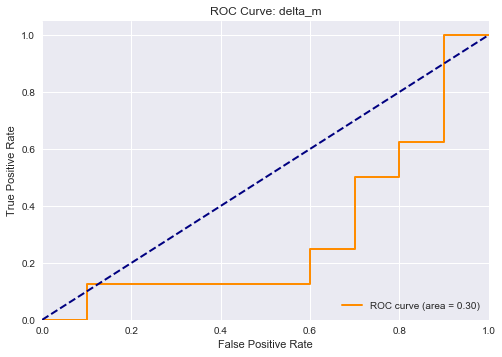

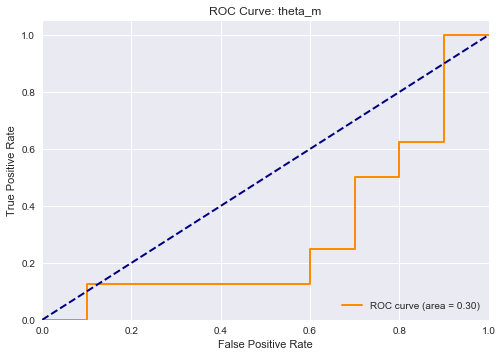

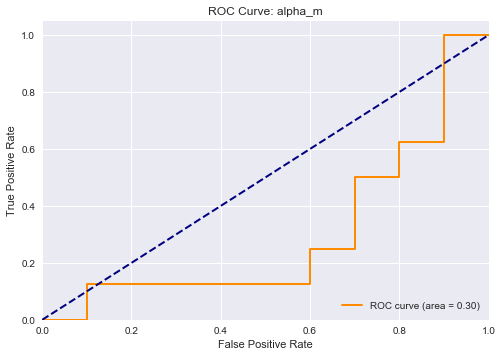

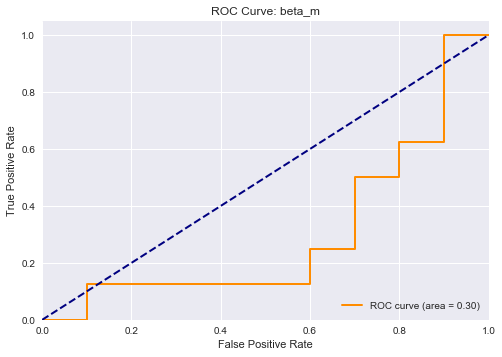

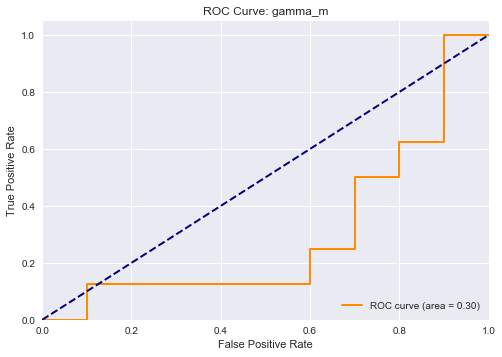

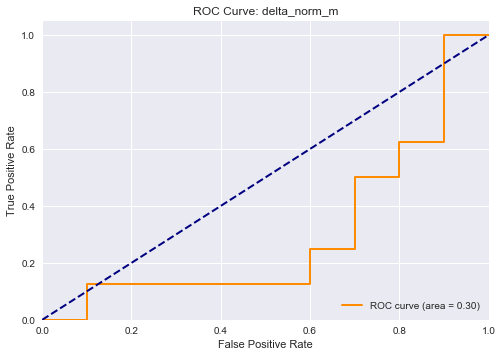

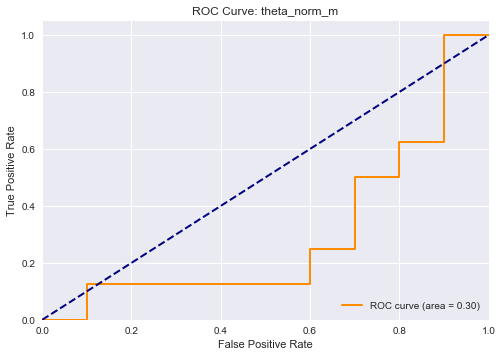

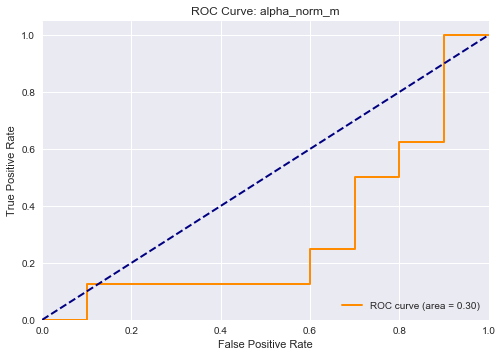

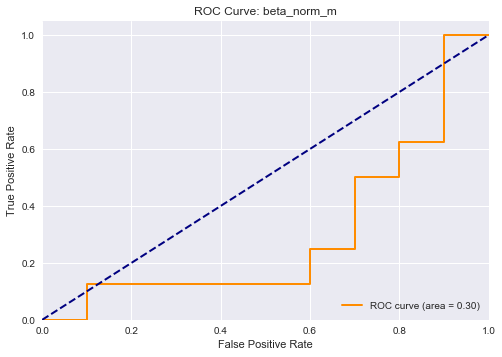

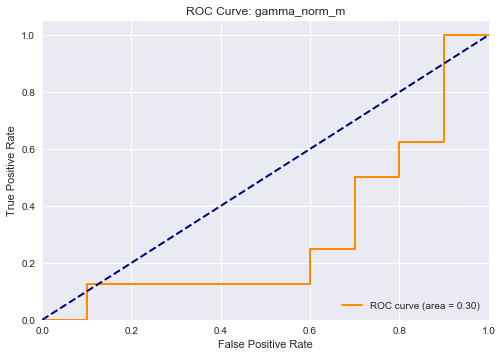

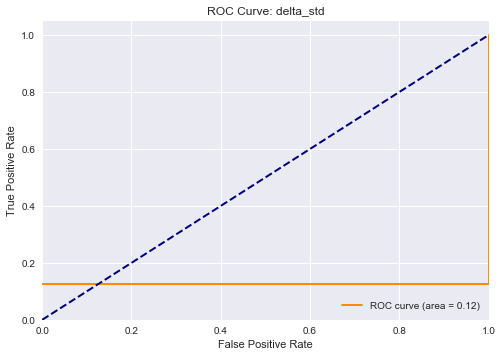

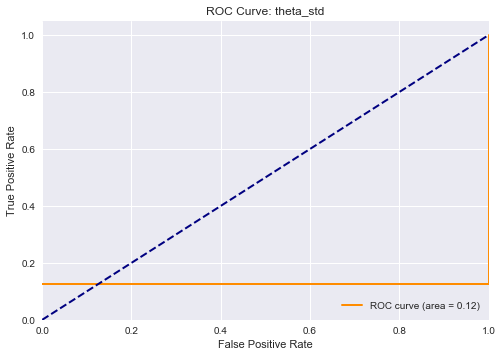

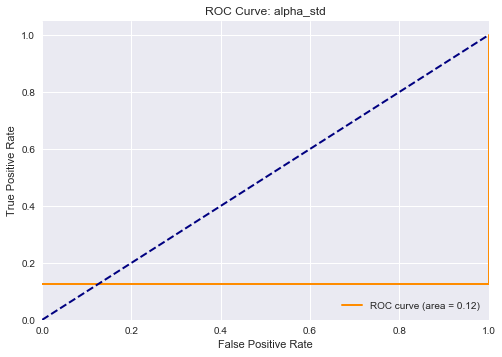

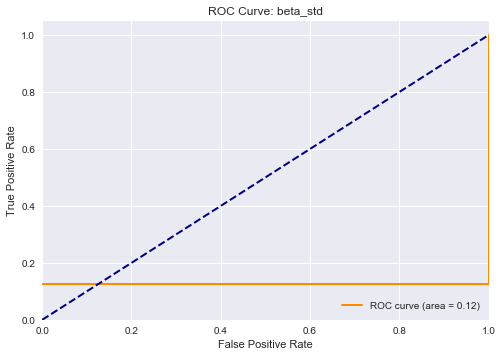

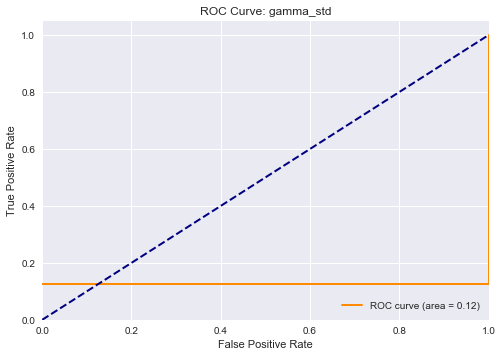

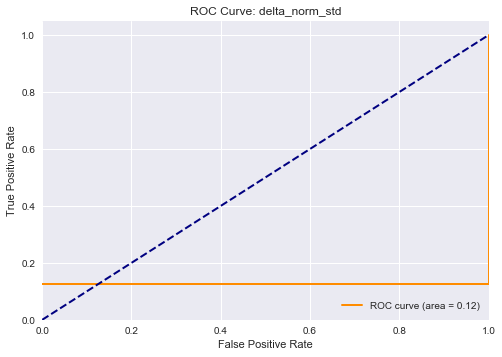

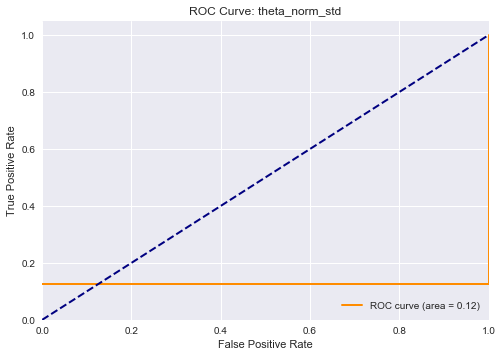

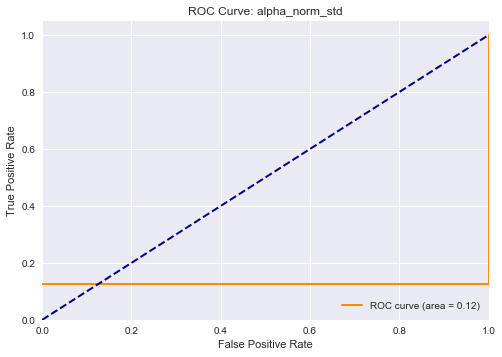

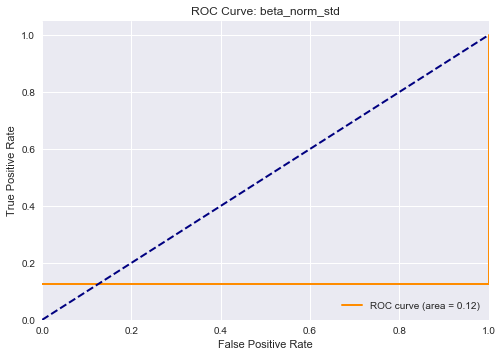

In [599]:
#TODO consultar
#ys =['P']*10+['S']*10
ys =['P']*10+['S']*8
featuresROC(df, ys)

In [607]:
def featuresCVROC(df, ys):
    
    for k in range(1,20):
        name = columnas[k]
        xs = np.concatenate(df.loc[:,[name]].values)
        plotCVROC(xs, ys, name)
   

In [629]:
#TODO consultar
def plotCVROC(xs, ys, name):
    y_true = label_binarize(ys, classes=['P', 'S']).ravel()
       
    # shuffle and split training and test sets
    xs_train, xs_test, y_train, y_test = train_test_split(xs, y_true, test_size=.5,
                                                    random_state=0)
    
    random_state = np.random.RandomState(0)
    # Learn to predict each class against the other
    classifier = OneVsRestClassifier(svm.SVC(kernel='linear', probability=True,
                                 random_state=random_state))
    
    y_score = classifier.fit(xs_train, y_train).decision_function(xs_test)

    # Compute ROC curve and ROC area for each class     
    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    #plt.title('Receiver operating characteristic example')
    plt.title('ROC Curve: ' + name)
    plt.legend(loc="lower right")
    plt.show()

In [636]:
#Consultar
#ValueError: Found input variables with inconsistent numbers of samples: [1, 9]

#ys =['P']*10+['S']*10
ys =['P']*10+['S']*8

#featuresCVROC(df, ys)

Una medida de información intra-electrodo (a elección)

Una medida de informacion inter-electrodo (a elección)